In [1]:
#mount Google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
#Unzip the dataset from google drive
#!unzip gdrive/My\ Drive/DL/deep-learning-for-msc-coursework-2022.zip

In [3]:

#Import libraries
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from PIL import Image
from torch.autograd import Variable
import torchvision
import pathlib
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [4]:
#use cuda otherwise the cpu
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
#Transforms
transformer=transforms.Compose([
                                transforms.Resize((32,32)),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize([0.5,0.5,0.5],
                                                     [0.5,0.5,0.5])                                
])

In [6]:
#Path for training, testing and prediction data

train_path = '/content/train/train'
test_path = '/content/test'
test1_path = '/content/test/test'
train_loader = DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=transformer),
    batch_size=256,shuffle=True
)

test_loader=DataLoader(
    torchvision.datasets.ImageFolder(test_path,transform=transformer),
    batch_size=256, shuffle=True
)

In [7]:
#List out all the categories/categorues
root=pathlib.Path(train_path)
categories=sorted([i.name.split('/')[-1] for i in root.iterdir()])

In [8]:
categories

['Cancer', 'Connective', 'Immune', 'Normal']

In [9]:
#class for defining CNN
class ConvNet(nn.Module):
    def __init__(self,num_categories=4):
        super(ConvNet,self).__init__()
        
        
        
        
        
        self.conv_1=nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,stride=1,padding=1)
        #Shape= (256,12,32,32)
        self.bn_1=nn.BatchNorm2d(num_features=12)
        #Shape= (256,12,32,32)
        self.relu_1=nn.ReLU()
        #Shape= (256,12,32,32)
        
        self.pool=nn.MaxPool2d(kernel_size=2)
        #Reducing the image size with factor of 2
        #Shape= (256,12,16,16)
        
        
        self.conv_2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
        #Shape= (256,20,16,16)
        self.relu_2=nn.ReLU()
        #Shape= (256,20,16,16)
        
        
        
        self.conv_3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        #Shape= (256,32,16,16)
        self.bn_3=nn.BatchNorm2d(num_features=32)
        #Shape= (256,32,16,16)
        self.relu_3=nn.ReLU()
        
        
        
        self.fc=nn.Linear(in_features=16 * 16 * 32,out_features=num_categories)
        
        
        
        #Feed forwad function
        
    def forward(self,input):
        output=self.conv_1(input)
        output=self.bn_1(output)
        output=self.relu_1(output)
            
        output=self.pool(output)
            
        output=self.conv_2(output)
        output=self.relu_2(output)
            
        output=self.conv_3(output)
        output=self.bn_3(output)
        output=self.relu_3(output)
            
            
        #The output of above matrix form, with shape (256,32,16,16)
            
        output=output.view(-1,32*16*16)
            
            
        output=self.fc(output)
            
        return output
        

In [10]:
model=ConvNet(num_categories=4).to(device)

In [11]:
#Optmizer and loss function
optimizer=Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()

In [12]:
num_epochs=15

In [13]:
#calculating the size of training and testing images
model_train_count=len(glob.glob(train_path+'/**/*.png'))
model_test_count=len(glob.glob(test_path+'/**/*.png'))

In [14]:
model_test_count


3200

In [15]:
#Model training and saving best model

model_best_accuracy=0.0
train_losses = []
# empty list to store test losses
val_losses = []
train_accuracy =[]
test_accuracy=[]
for epoch in range(num_epochs):
    
    #Evaluation and training on training dataset
    model.train()
    model_train_accuracy=0.0
    model_train_loss=0.0
    model_test_loss=0.0
    
    for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        optimizer.zero_grad()
        
        outputs=model(images)
        
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        
        
        model_train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        
        model_train_accuracy+=int(torch.sum(prediction==labels.data))
        
    model_train_accuracy=model_train_accuracy/model_train_count
    model_train_loss=model_train_loss/model_train_count
    train_losses.append(model_train_loss)
    train_accuracy.append(model_train_accuracy)
    
    
    # Model Evaluation on testing dataset
    model.eval()
    
    model_test_accuracy=0.0
    for i, (images,labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        outputs=model(images)
        model_test_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        model_test_accuracy+=int(torch.sum(prediction==labels.data))
        
    
    
    model_test_accuracy=model_test_accuracy/model_test_count
    model_test_loss=model_test_loss/model_test_count
    val_losses.append(model_test_loss)
    test_accuracy.append(model_test_accuracy)

    print('Epoch: '+str(epoch)+' Train Loss: '+str(model_train_loss)+' Train Accuracy: '+str(model_train_accuracy)+' Test Accuracy: '+str(model_test_accuracy))
    
    #Storing the sccuracy of best model
    if model_test_accuracy>model_best_accuracy:
        torch.save(model.state_dict(),'best_checkpoint.model')
        model_best_accuracy=model_test_accuracy
    

Epoch: 0 Train Loss: tensor(0.8796) Train Accuracy: 0.6941176470588235 Test Accuracy: 0.1140625
Epoch: 1 Train Loss: tensor(0.3419) Train Accuracy: 0.8758823529411764 Test Accuracy: 0.71
Epoch: 2 Train Loss: tensor(0.2294) Train Accuracy: 0.9141176470588235 Test Accuracy: 0.8284375
Epoch: 3 Train Loss: tensor(0.1936) Train Accuracy: 0.9329411764705883 Test Accuracy: 0.773125
Epoch: 4 Train Loss: tensor(0.1533) Train Accuracy: 0.9494117647058824 Test Accuracy: 0.5434375
Epoch: 5 Train Loss: tensor(0.1504) Train Accuracy: 0.9494117647058824 Test Accuracy: 0.3990625
Epoch: 6 Train Loss: tensor(0.1440) Train Accuracy: 0.951764705882353 Test Accuracy: 0.3828125
Epoch: 7 Train Loss: tensor(0.1240) Train Accuracy: 0.9576470588235294 Test Accuracy: 0.3846875
Epoch: 8 Train Loss: tensor(0.0995) Train Accuracy: 0.9652941176470589 Test Accuracy: 0.318125
Epoch: 9 Train Loss: tensor(0.0942) Train Accuracy: 0.9670588235294117 Test Accuracy: 0.3440625
Epoch: 10 Train Loss: tensor(0.0809) Train Accur

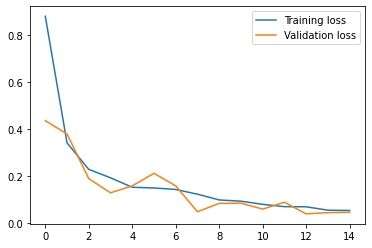

In [16]:
#Plot graph to show Training loss vs test loss
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.show()

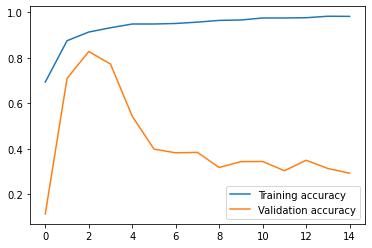

In [17]:
#Plot graph to show Training accuracy vs Test accuracy
plt.plot(train_accuracy, label='Training accuracy')
plt.plot(test_accuracy, label='Validation accuracy')
plt.legend()
plt.show()

In [18]:
#categories
root_path=pathlib.Path(train_path)
categories=sorted([i.name.split('/')[-1] for i in root_path.iterdir()])


In [19]:
categories

['Cancer', 'Connective', 'Immune', 'Normal']

In [20]:
checkpoint=torch.load('best_checkpoint.model')
model=ConvNet(num_categories=4)
model.load_state_dict(checkpoint)
model.eval()

ConvNet(
  (conv_1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu_1): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(12, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_2): ReLU()
  (conv_3): Conv2d(20, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu_3): ReLU()
  (fc): Linear(in_features=8192, out_features=4, bias=True)
)

In [21]:
transformer=transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                        [0.5,0.5,0.5])
])

In [22]:
images_path=glob.glob(test1_path+'/*.png')

In [23]:
#prediction function
def prediction_model(img_path,transformer):
    
    image=Image.open(img_path)
    
    image_tensform=transformer(image).float()
    
    
    image_tensform=image_tensform.unsqueeze_(0)
    
    if torch.cuda.is_available():
        image_tensform.cuda()
        
    input=Variable(image_tensform)
    
    
    output=model(input)
    
    index=output.data.numpy().argmax()
    
    pred=categories[index]
    
    return pred

In [24]:
prediction_dict={}

for i in images_path:
    prediction_dict[i[i.rfind('/')+1:]]=prediction_model(i,transformer)

In [25]:
prediction_dict

{'tile7085.png': 'Cancer',
 'tile5024.png': 'Cancer',
 'tile6678.png': 'Cancer',
 'tile6913.png': 'Cancer',
 'tile6096.png': 'Cancer',
 'tile7261.png': 'Cancer',
 'tile7360.png': 'Normal',
 'tile6429.png': 'Cancer',
 'tile7243.png': 'Cancer',
 'tile6519.png': 'Cancer',
 'tile6801.png': 'Cancer',
 'tile7578.png': 'Immune',
 'tile5878.png': 'Cancer',
 'tile7892.png': 'Cancer',
 'tile6898.png': 'Cancer',
 'tile5652.png': 'Cancer',
 'tile7087.png': 'Cancer',
 'tile7484.png': 'Cancer',
 'tile6599.png': 'Cancer',
 'tile5893.png': 'Normal',
 'tile6692.png': 'Cancer',
 'tile5970.png': 'Cancer',
 'tile5946.png': 'Cancer',
 'tile8010.png': 'Cancer',
 'tile6017.png': 'Cancer',
 'tile6362.png': 'Normal',
 'tile6601.png': 'Cancer',
 'tile7549.png': 'Normal',
 'tile7293.png': 'Cancer',
 'tile5478.png': 'Cancer',
 'tile5482.png': 'Cancer',
 'tile7474.png': 'Cancer',
 'tile6256.png': 'Cancer',
 'tile7647.png': 'Normal',
 'tile5725.png': 'Normal',
 'tile5609.png': 'Normal',
 'tile6663.png': 'Cancer',
 

In [26]:
import csv
import pandas as pd

with open('test.csv', 'w') as csv_file:  
    writer = csv.writer(csv_file)
    for key, value in prediction_dict.items():
       writer.writerow([key, value])

In [27]:
train_loader1 = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(train_path,transform=transformer), batch_size=256, num_workers=0)
test_loader1 = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(test_path,transform=transformer), batch_size=256, num_workers=0)

In [28]:
#Defining class for autoencoder
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
       
        #Encoder
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
       
        #Decoder
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 3, 2, stride=2)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.t_conv1(x))
        x = F.sigmoid(self.t_conv2(x))
              
        return x


In [29]:
model = ConvAutoencoder()
print(model)

ConvAutoencoder(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 3, kernel_size=(2, 2), stride=(2, 2))
)


In [30]:
def imshow(img):
    img = img / 2 + 0.5  
    plt.imshow(np.transpose(img, (1, 2, 0))) 

In [31]:
#Loss function
criterion = nn.BCELoss()

In [32]:
#Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [33]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

In [34]:
device = get_device()
print(device)
model.to(device)

cpu


ConvAutoencoder(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 3, kernel_size=(2, 2), stride=(2, 2))
)

In [40]:
n_epochs = 200

In [36]:
for epoch in range(1, n_epochs+1):
    # tracking training loss
    model_train_loss = 0.0

    #Training
    for data in train_loader1:
        images, _ = data
        images = images.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        model_train_loss += loss.item()*images.size(0)
          
    model_train_loss = model_train_loss/len(train_loader1)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, model_train_loss))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1 	Training Loss: 164.855746
Epoch: 2 	Training Loss: 164.342880
Epoch: 3 	Training Loss: 163.826698
Epoch: 4 	Training Loss: 163.281214
Epoch: 5 	Training Loss: 162.676088
Epoch: 6 	Training Loss: 161.941692
Epoch: 7 	Training Loss: 160.847846
Epoch: 8 	Training Loss: 159.111006
Epoch: 9 	Training Loss: 156.370772
Epoch: 10 	Training Loss: 152.246278


In [37]:
#Batch of test images
dataiter = iter(test_loader1)
images, labels = dataiter.next()

#Sample outputs
output = model(images)
images = images.numpy()

output = output.view(256, 3, 32, 32)
output = output.detach().numpy()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Original Images


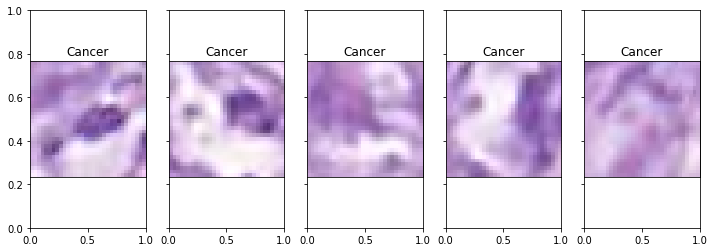

In [38]:
#Original Images
print("Original Images")
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(12,4))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(categories[labels[idx]])
plt.show()

Reconstructed Images


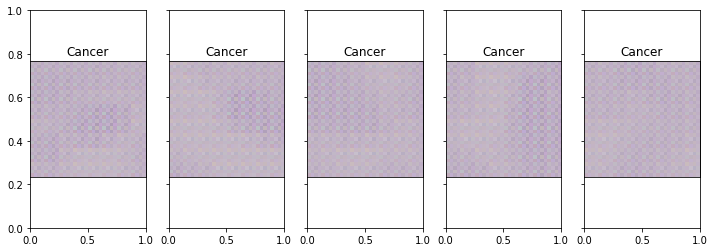

In [39]:
#Reconstructed Images
print('Reconstructed Images')
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(12,4))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    imshow(output[idx])
    ax.set_title(categories[labels[idx]])
plt.show() 